# 入门

- softmax 回归处理分类问题，模型有多个输出。对输出进行 softmax 处理。

- 模型，有 n 个预测类别时，启用 n 个回归运算，得到 n 给输出，如 3 个预测 / 输出时

o1 = x1 * w11 + x2 * w21 + ... + xn * wn1

o2 = x2 * w12 + x2 * w22 + ... + xn * wn2

o3 = x1 * w13 + x2 * w23 + ... + xn * wn3

- 对回归运行的输出 oi 进行归一化处理，得到 yi，使得输出更具有意义

yi = e^oi / Σoi^e

这样 Σyi == 1

- 矩阵化。

单个样本 **o**(i)

**o**(i) = **Wx**(i) + **b**

**y**^(i) = softmax(**o**(i))

多个样本 O

**O** = **WX** + **b**

**Y**^ = softmax(**O**)


## 定义分类问题的损失函数——交叉熵

- 问题，如果采用平方损失函数，则过于严格

例如真实样本的分类为 1 号，则 y=(1,0,0)，但是预测值为 y^=(0.6,0.2,0.2)，这个预测很准确，但是损失函数不为零。

- 交叉熵

交叉熵 H(yi,yi^) = - Σyi * ln(yi^)

可以看到，因为真实值 yi 是一个向量，只在分类对应位置是 1，其他是 0，所以交叉熵只管正确类别的预测。

由交叉熵定义的损失函数

L = (1/n) * ΣH(yi,yi^)


## 模型评价——准确率

准确率 = 正确预测数目 / 总数目

## 实战：图象分类数据集 Fashion-MNIST（1）

数据准备部分

In [1]:
# 导入本节需要的包或模块

%matplotlib inline
import d2lzh as d2l
from mxnet.gluon import data as gdata
import sys
import time

In [2]:
# 通过Gluon的data包来下载这个数据集。第一次调用时会自动从网上获取数据

# 训练数据
mnist_train = gdata.vision.FashionMNIST(train=True)
# 测试数据
mnist_test = gdata.vision.FashionMNIST(train=False)

60000 10000
(28, 28, 1) 2


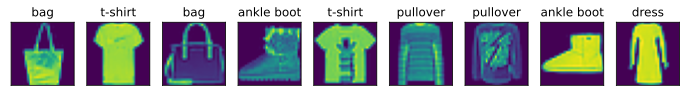

In [5]:
# 查看下载情况
print(len(mnist_train), len(mnist_test))

# 具体查看样本
feature, label = mnist_train[0]
print(feature.shape, label)
# (28, 28, 1) 表示图象分辨率 28*28，通道数 1 即灰度图

# 查看具体图像
X, y = mnist_train[9:18]
d2l.show_fashion_mnist(X, d2l.get_fashion_mnist_labels(y))

In [7]:
# 定义小批量数据读取的函数
# 我们通过ToTensor实例将图像数据从uint8格式变换成32位浮点数格式，并除以255使得所有像素的数值均在0到1之间
# ToTensor实例还将图像通道从最后一维移到最前一维来方便之后介绍的卷积神经网络计算。
def load_data_fashion_mnist(batch_size):
    transformer = gdata.vision.transforms.ToTensor()
    if sys.platform.startswith('win'):
        num_workers = 0  # 0表示不用额外的进程来加速读取数据
    else:
        num_workers = 4

    train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                                batch_size, shuffle=True,
                                num_workers=num_workers)
    test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                                batch_size, shuffle=False,
                                num_workers=num_workers)
    return train_iter, test_iter

# 测试
s = time.time()
train_iter,_ = load_data_fashion_mnist(256)
for X, y in train_iter:
    continue
print(f"用时{time.time()-s}s")

用时5.59700083732605s


## 实战：图象分类数据集 Fashion-MNIST（2）

从零实现 softmax 回归

In [8]:
# 读取数据集
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, nd

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [24]:
# 初始化模型参数
# 已知每个样本输入是高和宽均为28像素的图像
# 单层神经网络输出层的输出个数为10
num_inputs = 28 * 28
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

# 为模型参数附上梯度
W.attach_grad()
b.attach_grad()

In [13]:
# 实现softmax运算

# 先学习多维数组求和法则
# 只对其中同一列（axis=0）或同一行（axis=1）的元素求和
X = nd.array([[1, 2, 3], [4, 5, 6]])
print(X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True))

# 实现softmax运算
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制


[[5. 7. 9.]]
<NDArray 1x3 @cpu(0)> 
[[ 6.]
 [15.]]
<NDArray 2x1 @cpu(0)>


In [14]:
# 定义模型

# 这里通过reshape函数将每张原始图像改成长度为num_inputs的向量
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

In [17]:
# 定义损失函数
# y_hat 预测值 y，二维向量，例如 [0.1, 0.9] [0.8, 0.2]
# y 真实值，一维向量，如样本 1 和 2 的标签为 0 和 1，则 y = [0, 1]
# pick 函数就是一个分别按下标取值的函数，见下面介绍
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log()

# pick 函数就是一个分别按下标取值的函数
print(nd.pick(
    nd.array([[1,2,3],[4,5,6],[7,8,9]]),
    nd.array([0,2,1])
))



[1. 6. 8.]
<NDArray 3 @cpu(0)>


In [20]:
# 计算分类准确率
# y_hat.argmax(axis=1)返回矩阵y_hat每行中最大元素的索引
# 由于标签类型为整数，我们先将变量y变换为浮点数再进行相等条件判断
def accuracy(y_hat, y):
    return ((y_hat.argmax(axis=1) == y.astype('float32'))
        .mean().asscalar())

# 测试
print(accuracy(
    nd.array([
        [0.1,0.9],[0.8,0.2]
    ]),
    nd.array([1,1])
))

0.5


In [21]:
# 评估一个模型 net 的准确率
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

# 因为我们随机初始化了模型net，所以这个随机模型的准确率应该接近于类别个数10的倒数0.1
evaluate_accuracy(test_iter, net)

0.0856

In [25]:
# 训练模型
# 迭代次数 和 学习率（超参数）
num_epochs, lr = 5, 0.1

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)  # “softmax回归的简洁实现”一节将用到
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size,
          [W, b], lr)

epoch 1, loss 0.7875, train acc 0.747, test acc 0.799
epoch 2, loss 0.5733, train acc 0.810, test acc 0.822
epoch 3, loss 0.5292, train acc 0.822, test acc 0.832
epoch 4, loss 0.5054, train acc 0.830, test acc 0.838
epoch 5, loss 0.4900, train acc 0.833, test acc 0.842


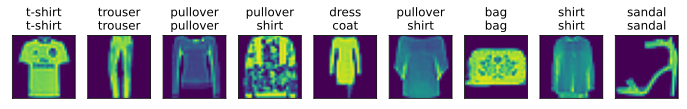

In [26]:
# 预测
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])